In [22]:
from transformers import AutoTokenizer, AutoConfig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import csv
import glob
import xml.etree.ElementTree as ET
from tqdm import tqdm
from wordcloud import WordCloud
from collections import defaultdict

# Question Parsing

In [2]:
tree = ET.parse('question_queries_normalized.xml')
root = tree.getroot()
question_queries = []
question_ids = []
question_map = dict()
print("Parsing all question queries")
for doc in tqdm(root):
    doc_dict =  dict()
    for attr in doc:
        attr_type = attr.tag
        attr_content = attr.text
        if attr_type not in doc_dict:
            doc_dict[attr_type.lower()] = ""
        else:
            tmp = doc_dict[attr_type.lower()]
            doc_dict[attr_type.lower()] = [tmp]
        if isinstance(doc_dict[attr_type.lower()], list):
            doc_dict[attr_type.lower()].append(attr_content)
        else:
            doc_dict[attr_type.lower()] = attr_content
    question_str = doc_dict["judul"]
    question_id = str(doc_dict["no"])
    question_map[question_id] = {
        "title": question_str,
        "text": doc_dict["isi"]
    }

    question_str += f'. {doc_dict["isi"]}'
    question_queries.append(question_str)
    question_ids.append(question_id)

Parsing all question queries


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 47858.33it/s]


In [3]:
question_map

{'1': {'title': 'cara mengatasi pusing , lemas dan hidung berair',
  'text': 'malam dok , sejak 2 hari yang lalu badan saya pusing dan lemas hari ini hidung saya mengeluarkan ingus terus menerus , bagaimana cara mengatasi nya ya dok ? terima kasih sebelumnya'},
 '2': {'title': 'telinga berdengung sebelah kiri',
  'text': 'selamat pagi dok , saya mau tanya kenapa telinga saya berdenging terus ya dok sudah 6 hari , saya juga sudah ke puskesmas untuk di periksa , kata dokternya telinganya kotor karena di bersihkan dengan cutton buds jadi kotorannya terdorong hingga menutupi gendang telinga , dan saya sudah dikasih obat tetes untuk menghilangkan kotoran , tetapi dengung di telinga saya tidak berkurang sama sekali dok , saran dari dokter seperti apa ?'},
 '3': {'title': 'benjolan di sekitar kelamin',
  'text': 'sore dok . . maaf dok saya sudah 4 hari mengalami benjolan di daerah kemaluan mula-mula benjolan tersebut kecil dan sekarang membesar lalu pecah dok . . rasanya linu dan sakit jika m

# Corpus Parsing

In [4]:
corpus_map = dict()
with open('corpus-syifa-normalized.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in tqdm(reader):
        corpus_map[str(row[0])] = {
            'title': row[2],
            'text': row[1]
        }
       

86731it [00:00, 122185.50it/s]


In [5]:
corpus_map

{'DS-1': {'title': 'mengapa keringat badan sangat berlebihan ?',
  'text': 'selamat malam dokter. ! saya fathurrosi umur 18 tahun saya memiliki masalah berkeringat berlebihan tanpa sebab saya sering sekali berkeringat secara berlebihan padahal saya tidak melakukan kegiatan apapun , teman-teman saya tidak berkeringat malah saya sendiri yang berkeringat , saya kurang pede kalau sudah berkeringat berlebihan seperti itu apakah untuk masalah ini ada tips atau cara mengatasi nya supaya saya bisa menyembuhkan masalah ini. ? mohon bantuannya terima kasih ! salam fathurrosi'},
 'DS-2': {'title': 'mengapa lengan atas sakit walaupun tidak melakukan aktivitas ?',
  'text': 'siang dokter mau tanya ? sudah 4 bulan lengan atas saya sakit jika melakukan pukulan smash atau lob keatas pada badminton . tidak melakukan aktivitas juga sakit . apa yang saya harus lakukan sendiri karena saya tidak mau ke dokter . saya sudah kompres dengan es batu tetapi belum sembuh juga . tolong saran dan informasinya ? ter

In [6]:
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p2', do_lower_case=True)

In [7]:
print(tokenizer.tokenize("hass", add_special_tokens=True, max_length=512, truncation=True))

['[CLS]', 'has', '##s', '[SEP]']


# Corpus Vocab 

In [8]:
def update_unknown_frequency(unknown_word_freq, tokens, unknown_word_lst):
    if len(tokens) == 0:
        return unknown_word_freq
    prefix = tokens[0]
    is_unknown = False
    for token in tokens:
        if is_unknown:
            if token.startswith("##"):
                prefix += token[2:]
            else:
                is_unknown = False
                unknown_word_freq[prefix] += 1
                unknown_word_lst.append(prefix)
                prefix = token
        else:
            if token.startswith("##"):
                is_unknown = True
                prefix += token[2:]
            else:
                prefix = token
    return unknown_word_freq, unknown_word_lst

In [9]:


unknown_words_corpus = defaultdict(int)
unknown_words_corpus_lst = []
pbar = tqdm(total=len(list(corpus_map.keys())), desc="Check unknown words")
for _, corpus_instance in corpus_map.items():
    tokenized_title = tokenizer.tokenize(corpus_instance['title'], max_length=512, truncation=True)
    tokenized_text = tokenizer.tokenize(corpus_instance['text'], max_length=512, truncation=True)
    tokenized_combined = tokenized_title + tokenized_text
    unknown_words_corpus, unknown_words_corpus_lst = update_unknown_frequency(unknown_words_corpus, tokenized_combined, unknown_words_corpus_lst)
    pbar.update(1)


Check unknown words: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 86707/86731 [00:26<00:00, 3482.17it/s]

In [10]:
sorted_unknown_words_corpus = sorted(unknown_words_corpus.items(), key=lambda x: x[1], reverse=True)    
print(sorted_unknown_words_corpus)

[('bentol', 1846), ('tanyadok', 1579), ('lajang', 1193), ('mimisan', 1075), ('ngilu', 1069), ('dahak', 815), ('kuret', 722), ('tht', 704), ('klikdokter', 656), ('tensi', 646), ('geraham', 638), ('berdahak', 634), ('mengganjal', 625), ('rontgen', 600), ('dokternya', 597), ('obt', 560), ('garuk', 544), ('bernanah', 531), ('thun', 530), ('sufor', 519), ('ingus', 504), ('iud', 502), ('kdang', 484), ('mencret', 477), ('benjolannya', 474), ('momongan', 461), ('trasa', 443), ('alaikum', 443), ('igg', 438), ('gatalnya', 436), ('penyembuhannya', 436), ('sertai', 430), ('kolestrol', 427), ('berbahayakah', 423), ('pnyakit', 423), ('haidnya', 420), ('testpack', 419), ('lukanya', 415), ('ditusuk', 407), ('nyerinya', 400), ('keloid', 400), ('jawabanya', 377), ('biduran', 374), ('periksakan', 371), ('linu', 370), ('panu', 365), ('prut', 359), ('stlah', 354), ('blan', 351), ('bgaimana', 351), ('normalkah', 343), ('kumat', 342), ('bronkitis', 338), ('bahayakah', 337), ('leukosit', 335), ('batuknya', 33

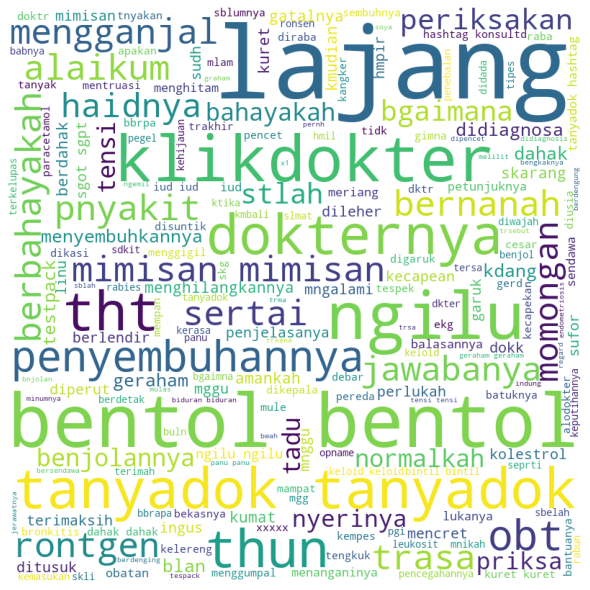

In [11]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(" ".join(unknown_words_corpus_lst))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Question Vocab

In [12]:
unknown_words_question = defaultdict(int)
unknown_words_question_lst = []
pbar = tqdm(total=len(list(question_map.keys())), desc=f"Tokenizing")
for qid, question_instance in question_map.items():
    tokenized_title = []
    tokenized_text = []
    if question_instance['title'] is not None:
        tokenized_title = tokenizer.tokenize(question_instance['title'], max_length=512, truncation=True)
    if question_instance['text'] is not None:
        tokenized_text = tokenizer.tokenize(question_instance['text'], max_length=512, truncation=True)
    tokenized_combined = tokenized_title + tokenized_text
    unknown_words_question, unknown_words_question_lst = update_unknown_frequency(unknown_words_question, tokenized_combined, unknown_words_question_lst)
    pbar.update(1)


Check unknown words: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86731/86731 [00:30<00:00, 2868.42it/s]


In [13]:
sorted_unknown_words_question = sorted(unknown_words_question.items(), key=lambda x: x[1], reverse=True)    
print(sorted_unknown_words_question)

[('mimisan', 4), ('berbahayakah', 3), ('aloe', 3), ('panic', 3), ('ligamen', 3), ('maladaptive', 2), ('daydreaming', 2), ('lebam', 2), ('belekan', 2), ('denyutan', 2), ('wassalamualaikum', 2), ('hbv', 2), ('sgpt', 2), ('mmol', 2), ('nyut', 2), ('indung', 2), ('disorder', 2), ('ingus', 1), ('berdengung', 1), ('berdenging', 1), ('dokternya', 1), ('cutton', 1), ('buds', 1), ('kotorannya', 1), ('dengung', 1), ('linu', 1), ('melamun', 1), ('berkhayal', 1), ('reflek', 1), ('mhswi', 1), ('smst', 1), ('poltekkes', 1), ('atensinya', 1), ('nunjuk', 1), ('merengeknya', 1), ('kebentur', 1), ('menuruni', 1), ('berkemih', 1), ('berkunang', 1), ('kunang', 1), ('silau', 1), ('taapi', 1), ('perantau', 1), ('belekannya', 1), ('pengelihatan', 1), ('menyembuhannya', 1), ('gastritis', 1), ('analisisnya', 1), ('epigastric', 1), ('ngeden', 1), ('babnya', 1), ('cemaskan', 1), ('meriang', 1), ('ekg', 1), ('sekarangpun', 1), ('pereda', 1), ('dipangkal', 1), ('mengganjal', 1), ('meraskan', 1), ('nemenukan', 1), 

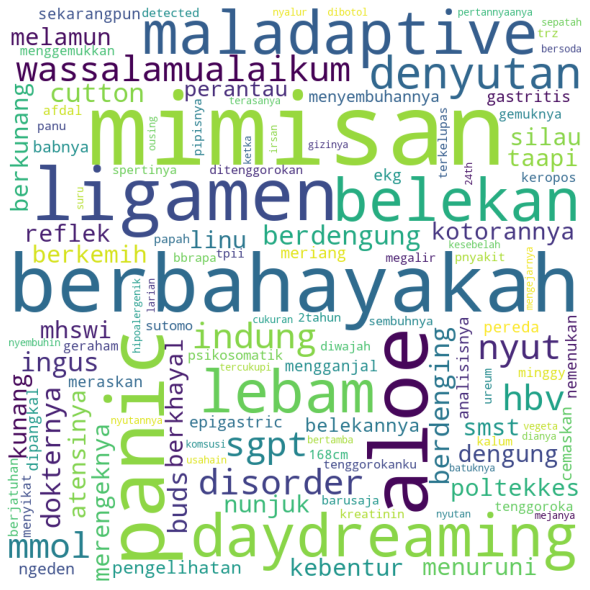

In [14]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(" ".join(unknown_words_question_lst))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# False Positive Check

In [78]:
with open('syifa_results_full_tydi.json', 'r') as f:
    res_json = json.load(f)

with open('question-syifa-test.json', 'r') as f:
    gold_json =  json.load(f)

In [79]:
res_json

[{'question': {'id': '1',
   'title': 'cara mengatasi pusing , lemas dan hidung berair',
   'text': 'malam dok , sejak 2 hari yang lalu badan saya pusing dan lemas hari ini hidung saya mengeluarkan ingus terus menerus , bagaimana cara mengatasi nya ya dok ? terima kasih sebelumnya'},
  'ctxs': [{'id': 'TD-7479',
    'title': 'trimaksh dok atas info nya , tetapi',
    'text': 'trimaksh dok atas info nya , tetapi saya sudah coba brusaha meng hentikan nya tetapi sulit sekali dok , bgai mana cara menghentikan nya',
    'score': '613.2973'},
   {'id': 'TD-11694',
    'title': 'selamat malam dok . maaf nie ! saya mau tanya ? telinga saya yang sebelah kanan kemasukan air , sampai sekarang masih sakit ! dan pndngaran saya yang sebelah kanan agak trganggu ! kira-kira .',
    'text': 'selamat malam dok . maaf nie ! saya mau tanya ? telinga saya yang sebelah kanan kemasukan air , sampai sekarang masih sakit ! dan pndngaran saya yang sebelah kanan agak trganggu ! kira-kira apa obat y dok ? m0 h0 n

In [80]:
neg_rels = dict()
for row in gold_json:
    qid = row['question']['id']
    neg_rel = []
    for neg_ctx in row['neg_ctxs']:
        neg_rel.append(neg_ctx['id'])
    neg_rels[qid] = neg_rel

In [81]:
unknown_words_all_neg_ctxs = dict()
unknown_words_all_neg_ctxs_lst = dict()
for qrow in res_json:
    qid = qrow['question']['id']
    unknown_words_neg_ctxs = defaultdict(int)
    unknown_words_neg_ctxs_lst = []
    for ctx in qrow['ctxs']:
        pid = ctx['id']

        if pid in neg_rels[qid]:
            tokenized_title = []
            tokenized_text = []
            if ctx['title'] is not None:
                tokenized_title = tokenizer.tokenize(ctx['title'], max_length=512, truncation=True)
            if question_instance['text'] is not None:
                tokenized_text = tokenizer.tokenize(ctx['text'], max_length=512, truncation=True)
            tokenized_combined = tokenized_title + tokenized_text
            unknown_words_neg_ctxs, unknown_words_neg_ctxs_lst = update_unknown_frequency(unknown_words_neg_ctxs, tokenized_combined, unknown_words_neg_ctxs_lst)
    unknown_words_all_neg_ctxs[qid] = sorted(unknown_words_neg_ctxs.items(), key=lambda x: x[1], reverse=True) 
    unknown_words_all_neg_ctxs_lst[qid] = unknown_words_neg_ctxs_lst

In [82]:
unknown_words_all_neg_ctxs

{'1': [],
 '2': [],
 '3': [],
 '4': [],
 '5': [],
 '6': [],
 '7': [],
 '8': [],
 '9': [],
 '10': [],
 '11': [],
 '12': [],
 '14': [],
 '15': [('eskrim', 1), ('mwngandung', 1)],
 '16': [('mengganjal', 2), ('mengedip', 1)],
 '17': [],
 '19': [],
 '20': [],
 '21': [],
 '23': [],
 '25': [],
 '26': [],
 '27': [],
 '28': [],
 '29': [],
 '30': [],
 '31': [],
 '32': [('ditusuk', 2),
  ('ceasar', 1),
  ('nmelahirkan', 1),
  ('nyerinya', 1),
  ('regards', 1)],
 '33': [],
 '34': [],
 '35': [],
 '36': [],
 '37': [],
 '38': [],
 '39': [],
 '41': [],
 '42': [],
 '43': [('baikan', 1)],
 '44': [('meberikan', 2), ('morniaga', 1), ('sufor', 1), ('alerginya', 1)],
 '45': [],
 '46': [],
 '47': [],
 '48': [],
 '49': [('ciprofloxaxin', 1),
  ('biotik', 1),
  ('bagiang', 1),
  ('linu', 1),
  ('ketulang', 1)],
 '50': [('thq', 1), ('adan', 1), ('erut', 1)]}

# True Positive Check

In [83]:
pos_rels = dict()
for row in gold_json:
    qid = row['question']['id']
    pos_rel = []
    for pos_ctx in row['ctxs']:
        pos_rel.append(pos_ctx['id'])
    pos_rels[qid] = pos_rel

In [84]:
unknown_words_all_pos_ctxs = dict()
unknown_words_all_pos_ctxs_lst = dict()
for qrow in res_json:
    qid = str(qrow['question']['id'])
    unknown_words_pos_ctxs = defaultdict(int)
    unknown_words_pos_ctxs_lst = []
    for ctx in qrow['ctxs']:
        pid = ctx['id']
        if pid in pos_rels[qid]:
            tokenized_title = []
            tokenized_text = []
            if ctx['title'] is not None:
                tokenized_title = tokenizer.tokenize(ctx['title'], max_length=512, truncation=True)
            if question_instance['text'] is not None:
                tokenized_text = tokenizer.tokenize(ctx['text'], max_length=512, truncation=True)
            tokenized_combined = tokenized_title + tokenized_text
            unknown_words_pos_ctxs, unknown_words_pos_ctxs_lst = update_unknown_frequency(unknown_words_pos_ctxs, tokenized_combined, unknown_words_pos_ctxs_lst)
    unknown_words_all_pos_ctxs[qid] = sorted(unknown_words_pos_ctxs.items(), key=lambda x: x[1], reverse=True) 
    unknown_words_all_pos_ctxs_lst[qid] = unknown_words_pos_ctxs_lst

In [86]:
unknown_words_all_pos_ctxs

{'1': [],
 '2': [('berdengung', 6),
  ('ttng', 2),
  ('beringus', 2),
  ('konfirmasinya', 2),
  ('aslm', 1),
  ('kalaw', 1),
  ('asslm', 1),
  ('kluhan', 1),
  ('mngidap', 1),
  ('mohin', 1),
  ('terimakasi', 1),
  ('wsslm', 1)],
 '3': [],
 '4': [('pendrita', 2), ('intsan', 1)],
 '5': [],
 '6': [('tenguk', 1),
  ('perlukah', 1),
  ('psikiater', 1),
  ('sasha', 1),
  ('menghantui', 1),
  ('dikucilkan', 1),
  ('histeris', 1),
  ('cnderung', 1),
  ('mmkir', 1),
  ('bukn', 1),
  ('mnyalah', 1),
  ('sendri', 1),
  ('shngga', 1),
  ('mnimbulkn', 1),
  ('brfikir', 1),
  ('mengahri', 1),
  ('khlangan', 1),
  ('nfsu', 1),
  ('brat', 1),
  ('smkin', 1),
  ('mnurun', 1),
  ('ucapkn', 1),
  ('krluarganya', 1),
  ('tida', 1),
  ('napsu', 1),
  ('hkan', 1),
  ('bdanpun', 1),
  ('pakah', 1),
  ('noviandi', 1),
  ('dangan', 1),
  ('menertawakan', 1),
  ('berucap', 1),
  ('parno', 1),
  ('uring', 1),
  ('uringan', 1)],
 '7': [],
 '8': [],
 '9': [],
 '10': [],
 '11': [('terlau', 1), ('tiru', 1)],
 '12':